In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#import tyssue
import sys
sys.path.append('/home/guillaume/Python/tyssue/src/py-tyssue/')
import pandas as pd
import numpy as np
import json
import matplotlib.pylab as plt

from scipy import optimize

from tyssue.core.sheet import Sheet

from tyssue.utils.utils import set_data_columns

import tyssue.geometry.sheet_geometry as geom
import tyssue.dynamics.sheet_vertex_model as model
import tyssue.solvers.sheet_vertex_solver as solver

from tyssue.dynamics.sheet_isotropic_model import isotropic_relax



from tyssue.draw.mpl_draw import sheet_view
import tyssue.draw.mpl_draw as draw
from tyssue.io import hdf5

In [3]:
h5store = 'small_hexagonal.hf5'
datasets = hdf5.load_datasets(h5store, data_names=['cell', 'jv', 'je'])
sheet = Sheet('emin', datasets)





### Datasets are made of dataframes 

They are manipulated as such.

```python
hdf5.save_datasets('small_hexagonal.hf5', sheet)

sheet.je_df.head()
sheet.cell_df.describe()
```

### Dataset Specifications

All the parameters are stored in **specifications**, which are nested dictionnaries.

for example:



In [4]:
geom_spec = geom.get_default_geom_specs()

In [5]:
set_data_columns(sheet, geom_spec)
geom.update_all(sheet, coords=sheet.coords)
sheet.cell_df.describe()

,perimeter,z,x,is_alive,area,y,old_idx,basal_shift,height,vol,vol_elasticity,prefered_height,contractility,prefered_area,num_sides,rho
count,56.000000,5.600000e+01,5.600000e+01,56.000000,56.000000,5.600000e+01,56.000000,56,5.600000e+01,56.000000,56,56,56.00,56,56,5.600000e+01
mean,10.654597,-3.370320e-16,-1.284687e-15,0.714286,9.163036,4.440892e-16,27.500000,4,8.540329e-01,7.825535,1,24,0.04,10,6,4.854033e+00
std,4.003702,5.972802e+00,3.319195e+00,0.455842,5.159561,3.319195e+00,16.309506,0,3.111507e-16,4.406435,0,0,0.00,0,0,8.800670e-16
min,4.380964,-8.253977e+00,-4.669287e+00,0.000000,1.078220,-4.669287e+00,0.000000,4,8.540329e-01,0.920836,1,24,0.04,10,6,4.854033e+00
25%,4.380964,-6.603181e+00,-3.258140e+00,0.000000,1.078220,-3.258140e+00,13.750000,4,8.540329e-01,0.920836,1,24,0.04,10,6,4.854033e+00
50%,13.164050,-2.590520e-16,-1.702342e-15,1.000000,12.396962,1.369275e-15,27.500000,4,8.540329e-01,10.587414,1,24,0.04,10,6,4.854033e+00
75%,13.164050,6.603181e+00,3.258140e+00,1.000000,12.396962,3.258140e+00,41.250000,4,8.540329e-01,10.587414,1,24,0.04,10,6,4.854033e+00
max,13.164050,8.253977e+00,4.669287e+00,1.000000,12.396962,4.669287e+00,55.000000,4,8.540329e-01,10.587414,1,24,0.04,10,6,4.854033e+00


we define the adimentional contractility $\bar\Gamma = \Gamma/K_vA_0h_0^2$ and line tension
$\bar\Lambda = \Lambda /K_v (A_0^{3/2}h_0^2)$, where $h_0$ is such that $V_0 = A_0h_0$.


In [6]:
# adim_parameters = model.default_params.copy()
### Testing aspect-ratio parametrization

mod_specs = model.get_default_mod_specs()
mod_specs['cell']['aspect'] = (6., np.float)
dim_mod_specs, norm_factor = model.dimentionalize(mod_specs)
set_data_columns(sheet, dim_mod_specs)


In [7]:

grad_err = solver.check_grad(sheet, sheet.coords)
grad_err /= norm_factor * sheet.Nc

print("Error on the gradient (non-dim, per cell): {:.3f}".format(grad_err))


Error on the gradient (non-dim, per cell): 0.004


In [8]:
kv_v0_ = model.elastic_force(sheet.cell_df,
                             var='vol',
                             elasticity='vol_elasticity',
                             prefered='prefered_vol')
kv_v0_.head()

cell
0   -239.079164
1   -229.412586
2   -229.412586
3   -229.412586
4   -229.412586
dtype: float64

In [11]:
isotropic_relax(sheet, **mod_specs)

In [12]:
grad_i, grad_t, grad_c, grad_v = model.compute_gradient(sheet, components=True)

In [13]:
grad_i.head() / norm_factor

,x,y,z
jv,,,
0,0.006950,-0.003959,-0.020885
1,-0.002228,-0.004667,0.015520
2,0.007714,0.002115,-0.020885
3,-0.004875,-0.001724,0.015520
4,-0.008222,0.002864,0.001139


In [14]:
Et, Ec, Ev = model.compute_energy(sheet, full_output=True)

0.886592687387 0.914285714286


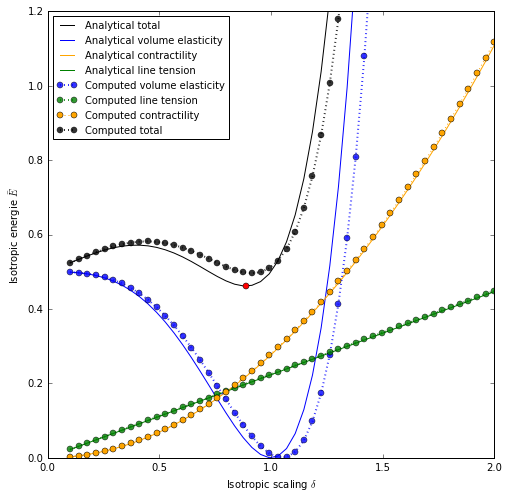

In [15]:

import tyssue.dynamics.sheet_isotropic_model as iso

%matplotlib inline
deltas = np.linspace(0.1, 2, 50)
fig, ax = plt.subplots(figsize=(8, 8))
lbda = mod_specs['je']['line_tension'][0]
gamma = mod_specs['cell']['contractility'][0]

mu = iso.mu ### Hexagone scaling constant


def elasticity(delta):
    return (delta**3 - 1 )**2 / 2.

def contractility(delta, gamma):
    return gamma * mu**2 * delta**2 / 2.

def tension(delta, lbda):
    return lbda * mu * delta / 2.


ax.plot(deltas, iso.isotropic_energy(deltas, mod_specs), 'k-',
        label='Analytical total')
ax.plot(sheet.delta_o, iso.isotropic_energy(sheet.delta_o, mod_specs), 'ro')
ax.plot(deltas, elasticity(deltas), 'b-',
        label='Analytical volume elasticity')
ax.plot(deltas, contractility(deltas, gamma), color='orange', ls='-',
        label='Analytical contractility')
ax.plot(deltas, tension(deltas, lbda), 'g-',
        label='Analytical line tension')

ax.set_xlabel(r'Isotropic scaling $\delta$')
ax.set_ylabel(r'Isotropic energie $\bar E$')

area0 = dim_mod_specs['cell']['prefered_area'][0]
h_0 = dim_mod_specs['cell']['prefered_height'][0]


### Cells only area and height
area_avg = sheet.cell_df[sheet.cell_df['is_alive'] == 1].area.mean()
rho_avg = sheet.cell_df[sheet.cell_df['rho'] == 1].area.mean()

### Set height and area to height0 and area0
delta_0 = (area0 / area_avg)**0.5
geom.scale(sheet, delta_0, sheet.coords)
sheet.cell_df['basal_height'] = rho_avg * delta_0 - h_0

geom.update_all(sheet)


energy = model.compute_energy(sheet)

norm = (norm_factor * sheet.cell_df.is_alive).sum()

energies = np.zeros((deltas.size, 3))
#scales = np.linspace(0.5, 1.2, 20) / eptm.delta_o
for n, delta in enumerate(deltas):
    geom.scale(sheet, delta,
               sheet.coords+['basal_shift'])
    geom.update_all(sheet)

    Et, Ec, Ev = model.compute_energy(sheet, full_output=True)
    energies[n, :] = [Et.sum(), Ec.sum(), Ev.sum()]
    geom.scale(sheet, 1/delta, sheet.coords+['basal_shift'])
    geom.update_all(sheet)

isotropic_relax(sheet)


energies = energies / norm
ax.plot(deltas, energies[:, 2], 'bo:', lw=2, alpha=0.8,
        label='Computed volume elasticity')
ax.plot(deltas, energies[:, 0], 'go:', lw=2, alpha=0.8,
        label='Computed line tension')
ax.plot(deltas, energies[:, 1], ls=':',
        marker='o', color='orange', label='Computed contractility')
ax.plot(deltas, energies.sum(axis=1), 'ko:', lw=2, alpha=0.8,
        label='Computed total')

ax.legend(loc='upper left', fontsize=10)
ax.set_ylim(0, 1.2)


print(sheet.delta_o, deltas[energies.sum(axis=1).argmin()])

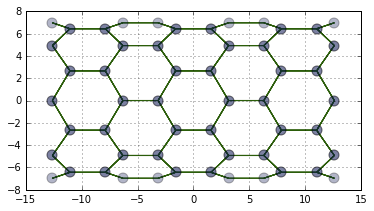

In [16]:
fig, ax = sheet_view(sheet, ['z', 'x'])

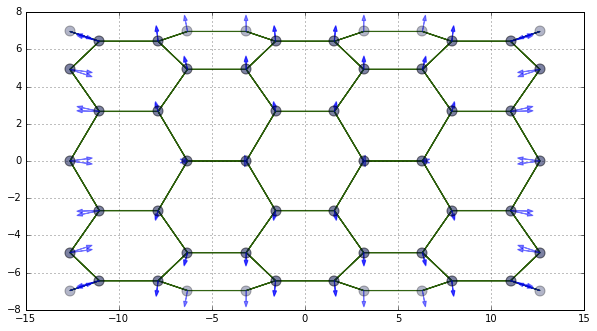

In [19]:
fig, ax = draw.plot_forces(sheet, model, ['z', 'y'], 
                           norm_factor/50)
fig.set_size_inches(10, 12)


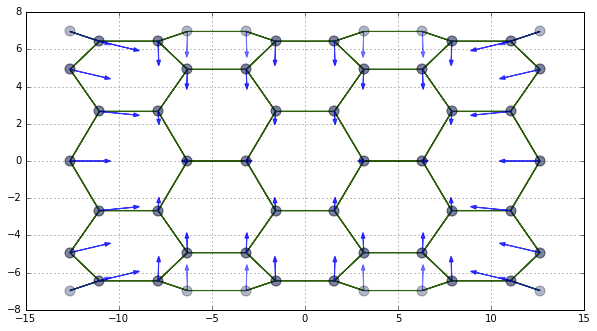

In [21]:
fig, ax = draw.plot_forces(sheet, model,
                          ['z', 'y'],
                          norm_factor/50,
                          approx_grad=solver.approx_grad)
fig.set_size_inches(10, 12)

In [ ]:
eptm.je_df.line_tension = eptm.je_df.line_tension * (np.cos(eptm.je_df.nz)**2 + 0.5)

In [ ]:
eptm.je_df.head(10)

In [ ]:
fig, ax = plot_gradients(eptm, ['z', 'y'])
fig, ax = plot_gradients(eptm, ['z', 'y'], ax=ax, approx=True, ec='b', fc='b')

fig.set_size_inches(10, 12)


In [ ]:
def plot_gradients(sheet, model,
                   norm_factor,
                   coords,
                   ax=None,
                   approx=False,
                   **draw_specs):
    """Plot the gradients, with their amplitudes divided
    by norm_factor
    """
    draw_specs.update(mpl_draw.get_default_draw_specs())
    gcoords = ['g'+c for c in coords]
    if approx:
        app_grad = model.approx_grad(sheet)
        grad_i = pd.DataFrame(index=sheet.jv_idx,
                              data=app_grad.reshape((-1, 3)),
                              columns=sheet.coords) / norm_factor

    else:
        grad_i = model.compute_gradient(sheet, components=False) / norm_factor

    arrows = pd.DataFrame(columns=coords + gcoords,
                          index=sheet.jv_df.index)
    arrows[coords] = sheet.jv_df[coords]
    arrows[gcoords] = grad_i[coords]

    if ax is None:
        fig, ax = sheet_view(sheet, coords, draw_specs)
    else:
        fig = ax.get_figure()

    for _, arrow in arrows.iterrows():
        ax.arrow(*arrow,
                 **draw_specs['jv']['grad_arrows'])

    return fig, ax


In [ ]:
plot_gradients(sheet, model,
               norm_factor,
               ['x', 'y'],
               ax=None,
               approx=False)